In [1]:
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import resnet

In [2]:
args = {'transform': transforms.Compose([ transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]),
                    'loader_tr_args':{'batch_size': 128, 'num_workers': 1},
                    'loader_te_args':{'batch_size': 100, 'num_workers': 1}, # change back to 1000
                    'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
                    'transformTest': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])}
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'      
         

In [3]:
def get_CIFAR10(path):
    data_tr = datasets.CIFAR10(path + '/CIFAR10', train=True, download=True)
    data_te = datasets.CIFAR10(path + '/CIFAR10', train=False, download=True)
    X_tr = data_tr.data
    Y_tr = torch.from_numpy(np.array(data_tr.targets))
    X_te = data_te.data
    Y_te = torch.from_numpy(np.array(data_te.targets))
    return X_tr, Y_tr, X_te, Y_te

class DataHandler3(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        if self.transform is not None:
            x = Image.fromarray(x)
            x = self.transform(x)
        return x, y, index

    def __len__(self):
        return len(self.X)

In [5]:
def get_handler(name):
    if name == 'CIFAR10':
        return DataHandler3

In [6]:
handler = get_handler('CIFAR10')

In [7]:
net = resnet.ResNet18(num_classes=4)
X_tr, Y_tr, X_te, Y_te = get_CIFAR10('data')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def calculate_dispersed_fishmask(device, net, handler, X, Y, args, pct_top=0.02):
    #---------------------------------Originally calculate_gradients---------------------------------
    net.to(device)
    for param in net.parameters():
        param.requires_grad = True
    net.eval()
    parameters = tuple(net.parameters())
    sq_grads_expect = {i: np.zeros(p.shape) for i, p in enumerate(parameters)}
    test_loader = DataLoader(handler(X, Y, transform=args['transform']), shuffle=False, **args['loader_te_args'])
    num_samples = 2 # used by FISH mask paper
    idx = 0
    for test_batch, test_labels, idxs in test_loader:
        if idx >= num_samples:
            break
        
        test_batch, test_labels = test_batch.cuda(), test_labels.cuda()
        outputs, e1 = net(test_batch)
        _, preds = torch.max(outputs, 1)        
        probs = F.softmax(outputs, dim=1).to('cpu')
        log_probs = F.log_softmax(outputs, dim=1)
        N, C = log_probs.shape
        #print(f'N:{N} C:{C}')
        for n in range(N):
            for c in range(C):
                grad_list = torch.autograd.grad(log_probs[n][c], parameters, retain_graph=True)
                #if n == 0:
                    #print(f'len:{len(grad_list)}')
                for i, grad in enumerate(grad_list):    # different layers
                    gsq = torch.square(grad).to('cpu') * probs[n][c] / N
                    sq_grads_expect[i] += gsq.detach().numpy() # sq_grads_expect[i] + gsq
                    del gsq
                net.zero_grad()
            idx += 1
            if idx >= num_samples:
                break
    
    grad_values = list(sq_grads_expect.values())
    imp_wt_idxs = [[] for i in range(len(grad_values))]
    for i in range(len(grad_values)): #layer-by-layer
        num_imp = pct_top * np.prod(np.array(grad_values[i]).shape)
        sorted_grads = np.argsort(grad_values[i])
        top_grad_idxs = sorted_grads[-int(num_imp):]
        top_grad_idxs = np.hstack([np.array(t).flatten() for t in top_grad_idxs])
        try:
            imp_wt_idxs[i] = np.nonzero([np.array(grad_values[i]).flatten()[top_grad_idxs] == grad_values[i]])
        except Exception:
                    print("caught error: ", i, len(np.array(grad_values[i]).flatten()), len(top_grad_idxs), top_grad_idxs)
                    raise
        #print(len(top_grad_idxs),len(imp_wt_idxs[i]))

    return imp_wt_idxs

In [40]:
parameters = tuple(net.parameters())
sq_grads_expect = {i: np.zeros(p.shape) for i, p in enumerate(parameters)}
grad_values = list(sq_grads_expect.values())
imp_wt_idxs = [[] for i in range(len(grad_values))]
pct_top = 0.02

In [52]:
for i in range(len(grad_values)): #layer-by-layer
    num_imp = pct_top * np.prod(np.array(grad_values[i]).shape)
    sorted_grads = np.argsort(grad_values[i])
    top_grad_idxs = sorted_grads[-int(num_imp):]
    top_grad_idxs = np.hstack([np.array(t).flatten() for t in top_grad_idxs])
    print(top_grad_idxs)

[0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1
 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2
 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1
 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1 2 ... 0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1 2 ... 0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1 2 ... 0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1 2 ... 0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12

In [43]:
for i in range(len(grad_values)): #layer-by-layer
    num_imp = pct_top * np.prod(np.array(grad_values[i]).shape)
    # num_imp = pct_top * len(grad_values[i])
    print(num_imp, np.prod(np.array(grad_values[i]).shape))

8.64 432
0.32 16
0.32 16
46.08 2304
0.32 16
0.32 16
46.08 2304
0.32 16
0.32 16
46.08 2304
0.32 16
0.32 16
46.08 2304
0.32 16
0.32 16
92.16 4608
0.64 32
0.64 32
184.32 9216
0.64 32
0.64 32
10.24 512
0.64 32
0.64 32
184.32 9216
0.64 32
0.64 32
184.32 9216
0.64 32
0.64 32
368.64 18432
1.28 64
1.28 64
737.28 36864
1.28 64
1.28 64
40.96 2048
1.28 64
1.28 64
737.28 36864
1.28 64
1.28 64
737.28 36864
1.28 64
1.28 64
1474.56 73728
2.56 128
2.56 128
2949.12 147456
2.56 128
2.56 128
163.84 8192
2.56 128
2.56 128
2949.12 147456
2.56 128
2.56 128
2949.12 147456
2.56 128
2.56 128
10.24 512


In [12]:
imp_wts = calculate_dispersed_fishmask(device, net, handler, X_tr, Y_tr, args, pct_top=0.01)

/tmp/ipykernel_397613/2478450762.py:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  imp_wt_idxs[i] = np.nonzero([np.array(grad_values[i]).flatten()[top_grad_idxs] == grad_values[i]])


In [24]:
print(imp_wts)

[[(array([2]), array([0]), array([1]), array([0]))], [(array([7]),)], [(array([7]),)], [(array([4]), array([1]), array([2]), array([2]))], [(array([4]),)], [(array([4]),)], [(array([2]), array([4]), array([1]), array([1]))], [(array([14]),)], [(array([14]),)], [(array([2]), array([2]), array([2]), array([0]))], [(array([2]),)], [(array([12]),)], [(array([2]), array([2]), array([0]), array([2]))], [(array([7]),)], [(array([7]),)], [(array([17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 22]), array([ 2,  2,  2,  2,  2,  2,  2,  2,  4,  4,  7,  9, 15,  2]), array([0, 0, 1, 0, 0, 1, 2, 2, 0, 1, 0, 1, 0, 0]), array([0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0]))], [(array([18]),)], [(array([11]),)], [(array([ 4,  4,  4,  8,  8,  8,  8,  8,  8, 12, 12, 12, 12, 18, 24, 24, 24,
       24, 24]), array([18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18]), array([0, 1, 2, 0, 0, 1, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 2, 2]), array([1, 1, 1, 1, 2, 0, 2, 1, 2, 1, 0, 2,

In [26]:
print(imp_wts)

[[(array([2]), array([0]), array([2]), array([2]))], [(array([9]),)], [(array([9]),)], [(array([4]), array([0]), array([0]), array([1]))], [(array([4]),)], [(array([4]),)], [(array([6]), array([4]), array([0]), array([2]))], [(array([4]),)], [(array([6]),)], [(array([2]), array([2]), array([2]), array([0]))], [(array([13]),)], [(array([12]),)], [(array([2]), array([2]), array([2]), array([2]))], [(array([14]),)], [(array([11]),)], [(array([17, 18]), array([2, 2]), array([0, 2]), array([0, 0]))], [(array([1]),)], [(array([1]),)], [(array([8]), array([18]), array([0]), array([2]))], [(array([23]),)], [(array([23]),)], [(array([12]), array([11]), array([0]), array([0]))], [(array([8]),)], [(array([23]),)], [(array([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2

In [13]:

frac_imp = {l: [] for l in range(len(imp_wts))}
for layer_num, param in enumerate(net.parameters()):
    frac_imp[layer_num] = [len(imp_wts[layer_num]) / np.prod(param.shape) for rd in range(len(imp_wts))]

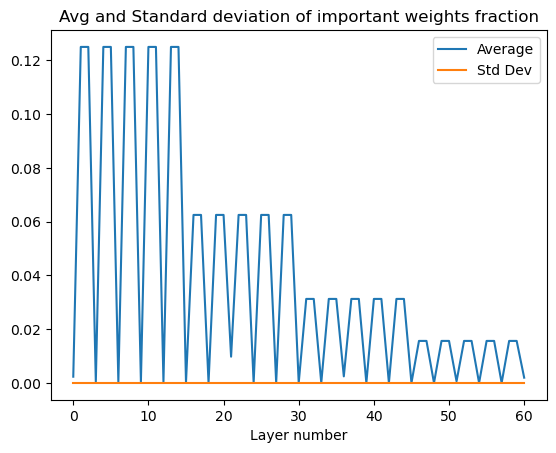

In [14]:
import matplotlib.pyplot as plt
plt.plot([np.average(frac_imp[l]) for l in range(61)], label='Average')
plt.plot([np.std(frac_imp[l]) for l in range(61)], label='Std Dev')
plt.xlabel('Layer number')
plt.title('Avg and Standard deviation of important weights fraction')
plt.legend()
plt.savefig("impwtsperlayerstats.png", format="png", dpi=5000)

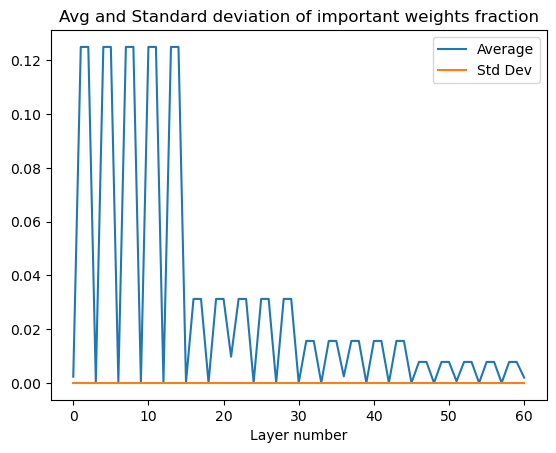

In [59]:
import matplotlib.pyplot as plt
plt.plot([np.average(frac_imp[l]) for l in range(61)], label='Average')
plt.plot([np.std(frac_imp[l]) for l in range(61)], label='Std Dev')
plt.xlabel('Layer number')
plt.title('Avg and Standard deviation of important weights fraction')
plt.legend()
plt.savefig("impwtsperlayerstats.png", format="png", dpi=5000)